# Restaraunt Location Based on Population Density in Minneapolis

# Part 1, The Business Problem
#### A client is opening a new restaurant in Minneapolis. They want to know about restaurants in the area and to get some advice on where to open the restaraunt, and what type of restaraunt to open. The data will be retrieved using the foursquare API using requests such as the one below. This is important because if the client opens their business in an innapropriate area, they could lose money.

In [1]:
!conda install -c conda-forge folium --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.10.1              |             py_0          59 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTAL

In [15]:
#Packages
import folium
from geopy.geocoders import Nominatim 
import json
from pandas.io.json import json_normalize
import pandas as pd
import requests
import urllib
from urllib.request import urlopen
import matplotlib.pyplot as plt

CLIENT_ID = '4LODPHDNFDBWNKDHOM0Y2UMHD0SVYV1KIUBKAJUFCX5JIEWT'
CLIENT_SECRET = 'D3EUBJ3Q2H4RO5RI3QNFA0Q2SVZMKV3KUE4FNCTQYTZUA3XQ'
VERSION = '20180604'
radius = 5000
LIMIT = 500

#Coordinates of Saint Paul, Downtown Minneapolis, Uptown, Northeast, Columbia Heights, Roseville, and St. Louis Park
locations = [[44.954445, -93.091301],[44.986656,-93.258133],[44.948964,-93.299869],
             [45.015363,-93.250879],[45.037833182, -93.257832302],[45.00608, -93.15661],[44.9597376, -93.3702186]]

In [18]:
#Load and convert the data from foursquare into a JSON object
results = []
for i in range(len(locations)):
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}&offset=20'.format(
        '4d4b7105d754a06374d81259',
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        locations[i][0], 
        locations[i][1], 
        radius,
        "restaurant",
        LIMIT)
    results.append(requests.get(url).json())
    
    

In [19]:
#Convert the JSON data into a DataFrame, then add the type of cuisine to the dataframe removing any duplicates

dflist = []
for i in range(len(results)):
    df = json_normalize(results[i]["response"]["venues"])
    genre = []
    for j in range(len(df)):
        category = df.iloc[j,0]
        l = json_normalize(category)
        genre.append(l.iloc[0,3])
    df["cuisine"] = genre
    dflist.append(df)
    
df = pd.concat(dflist,sort = True)
df = df.drop_duplicates(subset="name")
len(df)

220

In [34]:
df[["name","cuisine","location.lat","location.lng"]].head()

,name,cuisine,location.lat,location.lng
0,Sawatdee Thai Restaurant,Restaurant,44.950710,-93.093753
1,Sakura Restaurant & Sushi Bar,Sushi Restaurant,44.944471,-93.095099
2,Yarusso Brothers Italian Restaurant,Italian Restaurant,44.960824,-93.077331
3,New Saigon Restaurant,Vietnamese Restaurant,44.957587,-93.105757
4,The Commodore Bar and Restaurant,Lounge,44.943699,-93.118378


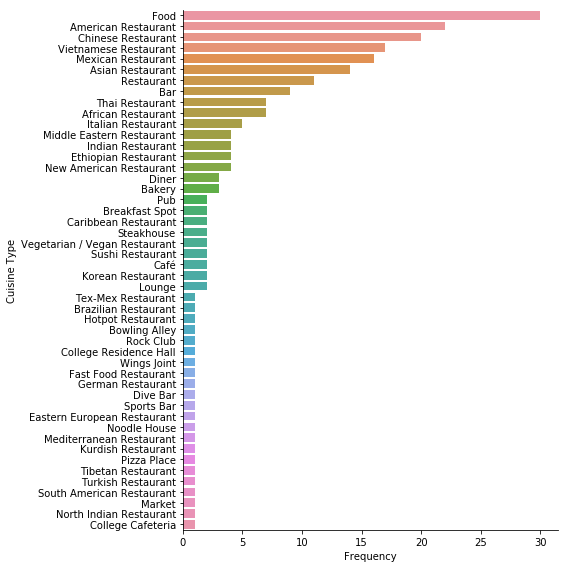

In [27]:
import seaborn as sns
import numpy as np

cuiscounts = pd.DataFrame(df["cuisine"].value_counts())
cuiscounts["name"] = cuiscounts.index

ax = sns.catplot(x = 'cuisine',y = 'name',data=cuiscounts,
            orient = 'h',height = 8,kind = 'bar')
ax.set(xlabel = "Frequency",ylabel = "Cuisine Type")
plt.show()

#### "Food" appears to be a catch-all term, NOT a term indicating a restaraunt that serves many types of food (such as Applebees) so it can effectively be ignored.

In [37]:
#Analyze what "Food" means as a label as it is the most common
df.loc[df['cuisine'] == "Food"]["name"]

30                    Samai Restaurant
33        Saigon Restaurant and Bakery
40             Queens Asian Restaurant
45                  Maria's Restaurant
48           Williams Restaurant World
14              Oddfellow's Restaurant
37           Vos Vietnamese Restaurant
40               Peterson's Restaurant
42              Alexander's Restaurant
19                 Giorgios Restaurant
33                 Renato's Restaurant
37                Le Bambou Restaurant
41                   Saigon Restaurant
44                Don Chilo Restaurant
4            Sullys Pub and Restaurant
5        La Tortuga Mexican Restaurant
6        Palm Court Bar and Restaurant
7                   Chiapas Restaurant
12                  Marinos Restaurant
24                Caribbean Restaurant
31                 R and Ds Restaurant
41                Brownie's Restaurant
12        African Soul Food Restaurant
23             Ground Round Restaurant
39          Boba Cafe Asian Restaurant
41          Brooklyn Cent

In [67]:
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster


mnMap = folium.Map(location = [df["location.lat"].mean(), df["location.lng"].mean()],
                   zoom_start = 11)

locationlist = df[["location.lat","location.lng"]].values.tolist()

mnMap.add_child(FastMarkerCluster(locationlist))
mnMap.save("Restaurant_Folium.html")
mnMap